In [1]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from scipy.stats import kendalltau
import os
import json
import joblib
import pandas as pd

In [2]:
from rural_beauty.config import models_dir
import importlib

module_name = "rural_beauty.config"
para_outcome = 'scenic'
para_type = 'xgb'
sugar    =  '121124'  # random identifier to have different models with same other paras
country = 'UK'


model_basename = f"{country}_{para_outcome}_{para_type}_{sugar}"

if not os.path.exists(models_dir / model_basename):
    os.mkdir(models_dir / model_basename)

# Import the module
config_module = importlib.import_module(module_name)

# Dynamically construct the variable name
feature_paths   = getattr(config_module, f"feature_paths_{country}")
BFN_features    = getattr(config_module, f"BFN_features_{para_outcome}")
predictors_path = getattr(config_module, f"predictors_{country}")
outcome_path    = getattr(config_module, f"outcome_{country}")
significant_coefs_path = models_dir / model_basename / "significant_coefs.csv"



This is the rural_beauty module


enable %%R cells in the notebook (mostly for vizualisation)

In [3]:
# Load the features paths dict
with open(feature_paths, "r") as f:
    features = json.load(f)


predictors_all = pd.read_csv(predictors_path, sep=",",  index_col=False, na_values = -99)

predictors = predictors_all

if 'hemero_1' in predictors.columns:
    predictors = predictors.drop('hemero_1', axis = 1)

predictors.tail(5)

,dem_1,dem_2,dem_3,seemee_1,wald_1,natgru_2,obst_1_4,stoer_1_2,stra_1_2,acker_1_4,...,geholz_1,strauc_1,moor_1,dorf_1,indgew_1,gewae_1,obst_1,mwald_1,meer_1,semage_1
4995,0.008451,0.019653,0.023521,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4996,0.021121,0.021407,0.016166,0.0,0.333954,0.000000,0.0,0.0,0.000000,0.813820,...,0.360210,0.026255,0.0,0.0,0.0,0.0,0.0,0.333954,0.0,0.0
4997,0.069544,0.068029,0.055238,0.0,0.077491,0.000000,0.0,0.0,0.018573,0.396976,...,0.077491,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4998,0.042292,0.064396,0.064736,0.0,0.872959,0.132675,0.0,0.0,0.014958,0.250518,...,0.872959,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4999,0.011264,0.012490,0.014674,0.0,0.000000,0.000000,0.0,0.0,0.075645,0.589215,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


Now the left hand side

In [4]:
outcome = pd.read_csv(outcome_path, sep=",",  index_col=False, na_values = -99)
outcome = outcome[para_outcome].to_frame()
outcome.tail(5)

,scenic
4995,4.557916
4996,3.923675
4997,4.435521
4998,5.869411
4999,4.299112


Split the Dataset

In [5]:
X    = predictors
Y    = outcome
feat = predictors.columns.values
print(X.shape)
print(Y.shape)

(5000, 67)
(5000, 1)


In [6]:
# Find rows with NaN values in X
na_rows_X = X.apply(lambda x: np.any(pd.isna(x)), axis=1)
resultx = np.where(na_rows_X)[0]

# Find rows with NaN values or values outside the rante in Y
na_rows_Y = Y.apply(lambda x: np.any(pd.isna(x)) or np.any((x < 1) | (x > 9)), axis=1)
resulty = np.where(na_rows_Y)[0]

# Combine the results
result = list(set(resulty).union(set(resultx)))

print('NA rows: ' + str(result))

NA rows: [np.int64(3844), np.int64(3333), np.int64(6), np.int64(2574), np.int64(2833), np.int64(19), np.int64(3605), np.int64(3355), np.int64(28), np.int64(2589), np.int64(2849), np.int64(2863), np.int64(4402), np.int64(824), np.int64(316), np.int64(4931), np.int64(1094), np.int64(2887), np.int64(3922), np.int64(4440), np.int64(99), np.int64(2920), np.int64(1641), np.int64(618), np.int64(616), np.int64(619), np.int64(4459), np.int64(3952), np.int64(2420), np.int64(2423), np.int64(631), np.int64(379), np.int64(1662), np.int64(4742), np.int64(3725), np.int64(1169), np.int64(2455), np.int64(410), np.int64(1691), np.int64(4765), np.int64(1956), np.int64(2215), np.int64(3241), np.int64(170), np.int64(173), np.int64(685), np.int64(2222), np.int64(2738), np.int64(3000), np.int64(1475), np.int64(3528), np.int64(2505), np.int64(3280), np.int64(466), np.int64(1235), np.int64(4562), np.int64(1751), np.int64(2264), np.int64(2534), np.int64(3307), np.int64(3564), np.int64(2550), np.int64(3576), np.

In [7]:
X = X.drop(X.index[result])
Y = Y.drop(Y.index[result])

print(X.shape)
print(Y.shape)

(4934, 67)
(4934, 1)


In [8]:
# from float to classes
Y[para_outcome] = Y[para_outcome].clip(lower=1, upper=9).round(0)

In [9]:
from collections import Counter
Counter(Y[para_outcome].round())

Counter({4.0: 1519,
         5.0: 1204,
         3.0: 875,
         6.0: 703,
         7.0: 285,
         2.0: 271,
         8.0: 61,
         1.0: 13,
         9.0: 3})

Create 4 dataset for training and testing the algorithm 

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y[para_outcome], test_size=0.5, random_state=2024, stratify = Y)


In [11]:
from rural_beauty.config import models_dir

model_folder = models_dir / model_basename

normalizer_X = model_folder / 'scaling_X.pkl'
normalizer_Y = model_folder / 'scaling_Y.pkl'

# Normalizing the data
# scaler_X = StandardScaler()
# scaler_Y = StandardScaler()

# Fit the scaler on the training data and transform both training and testing data
# X_train = scaler_X.fit_transform(X_train)
# X_test = scaler_X.transform(X_test)
# Y_train = scaler_Y.fit_transform(Y_train).ravel()
# Y_test = scaler_Y.transform(Y_test).ravel()


# joblib.dump(scaler_X, normalizer_X) 
# joblib.dump(scaler_Y, normalizer_Y) 

In [15]:
base_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
param_grid = {
    'n_estimators': [10, 20 ,50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': np.linspace(0, 1, 5),
    'colsample_bytree': np.linspace(0, 1, 5)
}

In [16]:
from sklearn.metrics import make_scorer

def kendall_tau_scorer(y_true, y_pred):
    tau, _ = kendalltau(y_true, y_pred)
    return tau

kendall_scorer = make_scorer(kendall_tau_scorer, greater_is_better=True)

In [18]:
# Set up GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=base_model, param_grid=param_grid, cv=5, scoring=kendall_scorer, n_jobs=-1)

# Fit the model with GridSearchCV
grid_search.fit(X_train, Y_train)

# Best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the model with best parameters on the full training set
model = xgb.XGBRegressor(**best_params, objective='reg:squarederror', random_state=42)
model.fit(X_train, Y_train)



/h/u145/hofer/MyDocuments/Granular/beauty/.venv/lib/python3.10/site-packages/sklearn/model_selection/_search.py:1102: UserWarning: One or more of the test scores are non-finite: [       nan 0.51553026 0.51913718 0.52072012 0.51854942        nan
 0.51104613 0.51413357 0.51708422 0.51516718        nan 0.53266841
 0.53544252 0.53805163 0.53637075        nan 0.55153985 0.55199045
 0.55451945 0.55265144        nan 0.55005417 0.55025539 0.55129412
 0.5501948         nan 0.50398541 0.51243077 0.51518255 0.51351201
        nan 0.5040344  0.50833607 0.51227628 0.51121418        nan
 0.52415685 0.5325623  0.53401259 0.5333437         nan 0.54648594
 0.54973435 0.55097894 0.55021723        nan 0.54532721 0.54655471
 0.54790899 0.54620465        nan 0.51557285 0.51817336 0.52047654
 0.51856831        nan 0.51375414 0.51611403 0.51949334 0.51782471
        nan 0.53406181 0.539469   0.54052218 0.53906006        nan
 0.54909721 0.55161043 0.55258807 0.55207492        nan 0.5501215
 0.5512895  0.55244

Best Hyperparameters: {'colsample_bytree': np.float64(0.5), 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': np.float64(0.75)}


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=np.float64(0.5), device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [14]:
from sklearn.metrics import root_mean_squared_error
# Make predictions
Y_pred_train = model.predict(X_train)
Y_pred_test = model.predict(X_test)

print(np.sqrt(root_mean_squared_error(Y_test, Y_pred_test)))


accuracy = accuracy_score(Y_test, Y_pred_test.round())
tau, p_value = kendalltau(Y_test, Y_pred_test)
print("Accuracy:", accuracy)
print("----------")
print("Kendall's Tau:", tau)
print("P-value:", p_value)

0.9578062760293684
Accuracy: 0.4089987839481151
----------
Kendall's Tau: 0.5510658709631214
P-value: 2.7450101681837944e-306


In [36]:

feature_importances = model.feature_importances_

# Optionally, create a DataFrame to view feature names and their importance scores
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)


In [37]:
joblib.dump(model, model_folder / 'model.pkl')

significant_coefs_path = model_folder / "significant_coefs.csv"

feature_importance_df.to_csv(significant_coefs_path, index = False)


In [44]:
import matplotlib.pyplot as plt
def plot_predicted_vs_actual(y_true, y_pred):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, edgecolor='k', alpha=0.7)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.show()

def plot_predicted_vs_actual_with_jitter(y_true, y_pred, jitter_amount=0.02):
    # Adding jitter: add normally distributed noise to both y_true and y_pred
    jitter_y_true = y_true + np.random.normal(0, jitter_amount, y_true.shape)
    jitter_y_pred = y_pred + np.random.normal(0, jitter_amount, y_pred.shape)

    plt.figure(figsize=(10, 6))
    plt.scatter(jitter_y_true, jitter_y_pred, edgecolor='k', alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Predicted vs. Actual Values with Jitter')
    plt.grid(True)
    plt.show()



def custom_accuracy_within_one_class(y_true, y_pred):
    correct = np.sum(np.abs(y_true - y_pred) <= 1)
    total = len(y_true)
    return correct / total

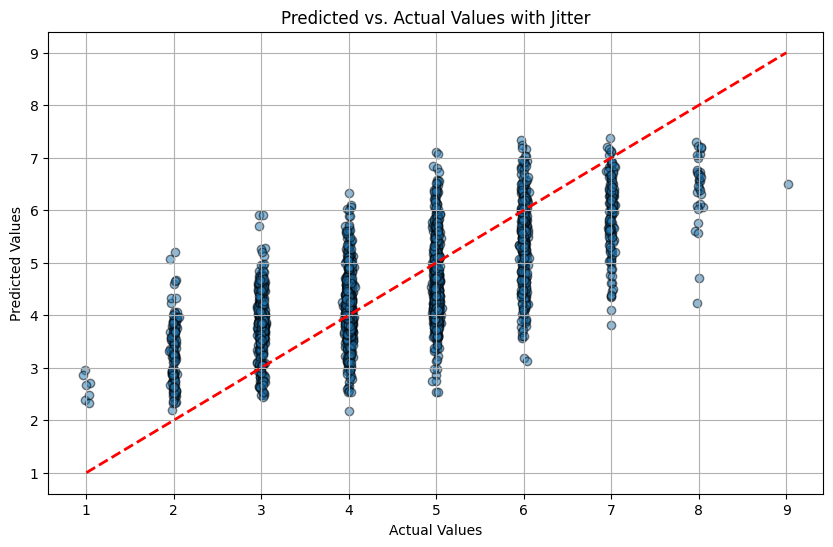

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_predicted_vs_actual_with_jitter(Y_test, Y_pred_test)
predvtrue_path = models_dir / model_basename / "predvtrue.png"
plt.savefig(predvtrue_path, format="png", dpi=300)